# Credit card fraud detection using ensemble deep embedded clustering (EDEC)

In this notebook we introduce the source code of a novel method for detecting potential fraud transactions in credit cards.

## Contents 

<ol>
    
<li> <h4>Data preparation </h4>
    <ol>
        <li>Data loading</li>
        <li>Data normalization</li>
        <li>Data resampling</li>
        <li>Input space visualization</li>
    </ol>
</li>
<li><h4>K-means clustering</h4>
    <ol>
        <li>Build k-means model</li>
        <li>Train (fit) the model</li>
        <li>Evaluate k-means on balanced data</li>
        <li>Evaluate k-means on imbalanced data</li>
    </ol>
</li>
    <li><h4>Autoencoder</h4>
    <ol>
        <li>Build autoencoder</li>
        <li>Pre-train autoencoder</li>
        <li>Feature space visualization</li>
    </ol>
</li>
<li><h4>Deep Embedded clustering (DEC)</h4>
    <ol>
        <li>Build DEC model</li>
        <li>Initialize cluster centers</li>
        <li>Train DEC model</li>
        <li>Evaluate DEC on balanced data</li>
        <li>Evaluate DEC on imbalanced data</li>
        <li>Evaluate ensemble DEC on balanced data</li>
        <li>Evaluate ensemble DEC on imbalanced data</li>
    </ol>
</li>
</ol>

In [1]:
# Import necessary libraries and dependencies
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import metrics
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
from IPython.display import Image
import collections
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import pickle

# set resolution
plt.rcParams["figure.dpi"] = 300

Using TensorFlow backend.


## 1. Data preparation
In this section of the notebook we perform various data preparation techniques before fitting it to clustering models.

### 1.1 Data loading
The first step is to load the data from CSV file as a data frame object using pandas library, then split the labels apart from the rest of features.

In [2]:
data_df = pd.read_csv('data/creditcard.csv')
data_df.drop(["Time"],axis=1,inplace=True)
data_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Store features in 'X' and labels in 'y'
X = data_df.iloc[:,data_df.columns!="Class"]
y = data_df.iloc[:,data_df.columns=="Class"]['Class']

print("Features shape: ", X.shape)
print("Labels shape: ", y.shape)

Features shape:  (284807, 29)
Labels shape:  (284807,)


### 1.2 Data normalization
After we loaded the data set, we need to perform a normalization operation on the features in order for features to have the same range of small values from 1 to -1. We do that by dividing the values of each feature by the maximium absolute value in that feature.

In [4]:
for col in X.iteritems():
    X[col[0]] /= max(abs(X[col[0]].min()), X[col[0]].max())
X.head()

c:\users\belal\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.024107,-0.001001,0.052485,0.081667,-0.002974,0.006308,0.001987,0.001348,0.023327,0.003693,...,0.004613,-0.000526,0.025412,-0.002466,0.014599,0.012485,-0.053766,0.004225,-0.000622,0.005824
1,0.021129,0.003660,0.003445,0.026557,0.000528,-0.001124,-0.000653,0.001162,-0.016379,-0.006791,...,-0.001268,-0.006482,-0.058416,0.002261,-0.074129,0.016237,0.035792,-0.000284,0.000435,0.000105
2,-0.024081,-0.018430,0.036693,0.022505,-0.004424,0.024563,0.006563,0.003383,-0.097124,0.008445,...,0.009633,0.007120,0.070582,0.020296,-0.150349,-0.031824,-0.039546,-0.001751,-0.001765,0.014739
3,-0.017130,-0.002547,0.037102,-0.051157,-0.000091,0.017015,0.001970,0.005155,-0.088940,-0.002235,...,-0.003817,-0.003109,0.000482,-0.004247,-0.256421,0.062880,-0.063096,0.001984,0.001816,0.004807
4,-0.020533,0.012071,0.032048,0.023883,-0.003580,0.001309,0.004917,-0.003695,0.052436,0.030627,...,0.007497,-0.000271,0.073015,-0.003068,0.030814,-0.020010,0.142804,0.006941,0.006356,0.002724


In [5]:
# Make a copy of the original imbalanced data for evaluation process
X_imb = X
y_imb = y

### 1.3 Data resampling

The final step in data preparation is resampling the data.  We do that by first oversample the minority class to have 30% the number of instances in the majority class, then using random sampling to undersample the majority class to have the same number of instances as the minority class.

In [6]:
# Buils the resampling pipeline
oversampling_ratio = 0.3 #0.011
undersampling_ration = 0.5
over = SMOTE(sampling_strategy=oversampling_ratio)
under = RandomUnderSampler(sampling_strategy=undersampling_ration)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [7]:
# Fit the pipeline and resample the data
X, y = pipeline.fit_resample(X_imb, y_imb)

print("Features shape: ", X.shape)
print("Labels shape: ", y.shape)

Features shape:  (255882, 29)
Labels shape:  (255882,)


In [8]:
# Display the number of fraud Vs. non-fraud instances after resampling process
non_fraud = y[y == 0]
fraud = y[y == 1]
print("non_fraud: ",non_fraud.shape)
print("fraud: ", fraud.shape)

non_fraud:  (170588,)
fraud:  (85294,)


### 1.4 Input space visualization
To take a deep insight into the nature of data we use TSNE algorithm to visualize how data points are distributed across the input space using a sample of only 6000 instances.

In [ ]:
#Build the model
tsne = TSNE(n_components=2)

#Fit the model and transform the features
X_embedded = tsne.fit_transform(X)
print("X_embedded shape: ", X_embedded.shape)

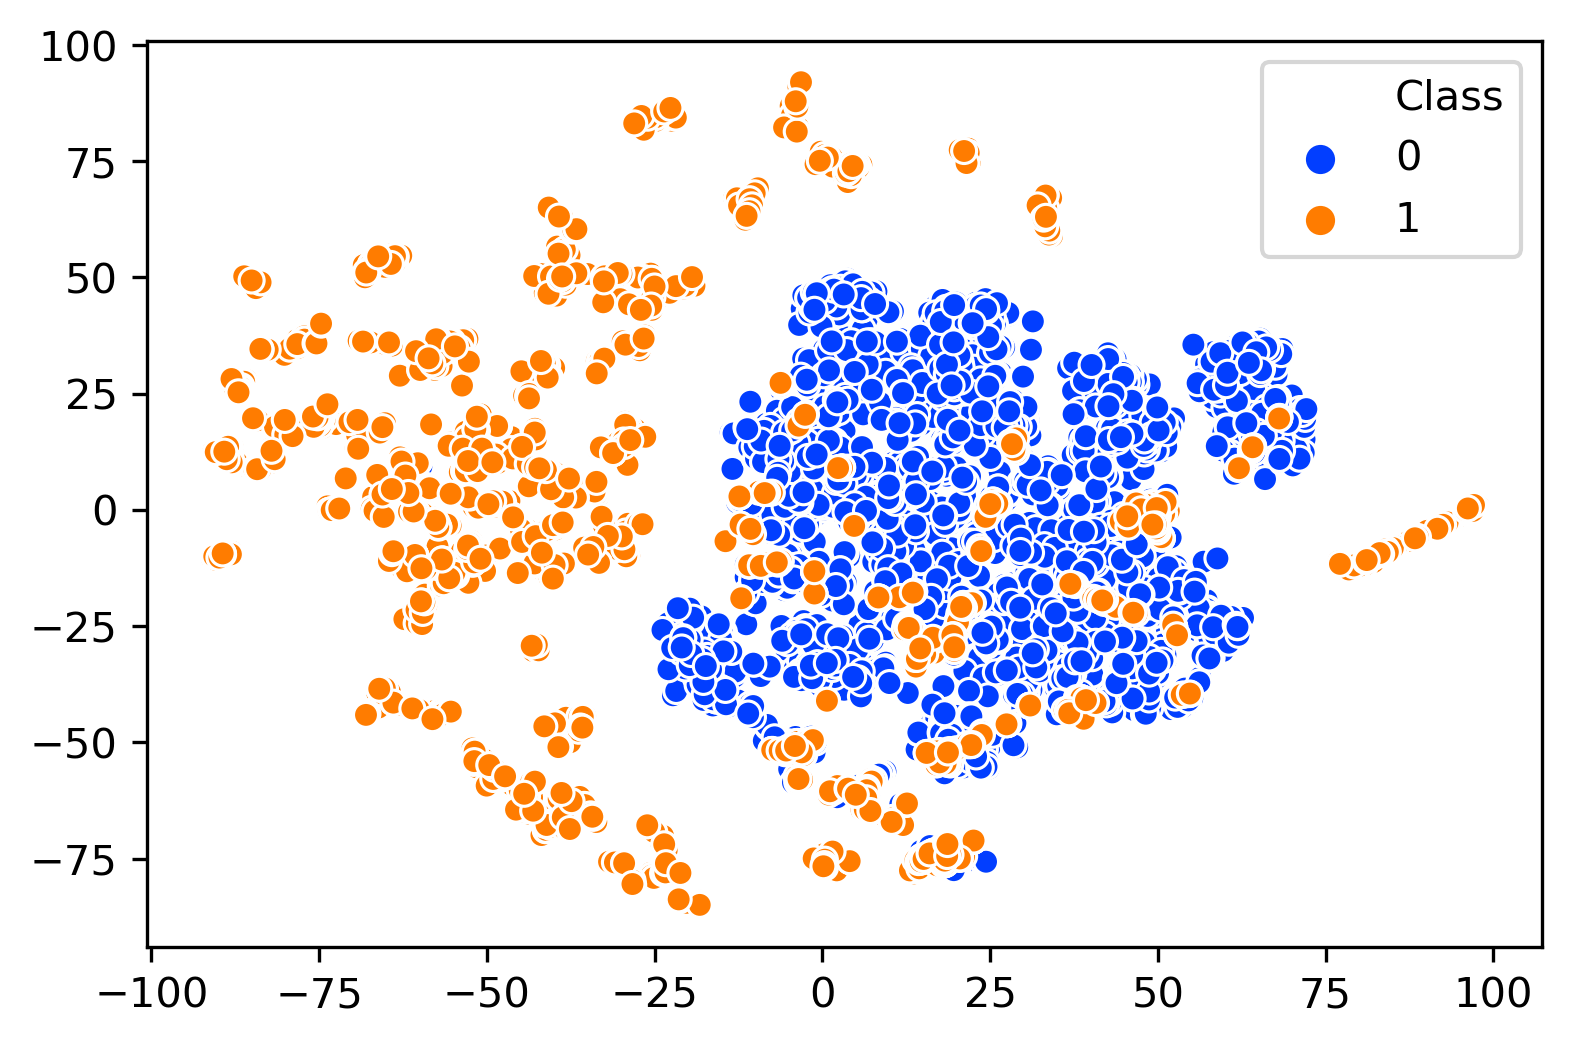

In [10]:
# Scatter plot the transformed features
palette = sns.color_palette("bright", 2)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, palette=palette)

## 2. K-means clustering

In this section of the notebook, we provide the source code of the baseline model which is a k-means model. We run the baseline 20 times and pick up the run that has the best results.

### 2.1 Build k-means model
First, we build the k-means model with 2 clusters and max iterations of 300.

In [9]:
kmeans = KMeans(n_clusters=2, max_iter=3000, n_init=20)

### 2.2 Train (fit) the model
Here we fit the k-means model with the balanced dataset.

In [10]:
# Fit and then store predictions in y_pred_kmeans
y_pred_kmeans = kmeans.fit_predict(X)

In [11]:
pickle.dump(kmeans.cluster_centers_, open("baseline/3to4_3.pkl", "wb"))
#k_centers2 = pickle.load(open("centers.pkl", "rb"))

In [9]:
b1 =  pickle.load(open("baseline/1to1_1.pkl", "rb"))
b2 =  pickle.load(open("baseline/1to1_2.pkl", "rb"))
b3 =  pickle.load(open("baseline/1to1_3.pkl", "rb"))
centers = (b1+b2+b3) / 3.0

### 2.3 Evaluate k-means on balanced data

In [11]:
metrics.acc(y, y_pred_kmeans)

c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.8408524241642632

In [14]:
# Print the number of predicted instances in each class.
collections.Counter(y_pred_kmeans)

Counter({0: 131090, 1: 39498})

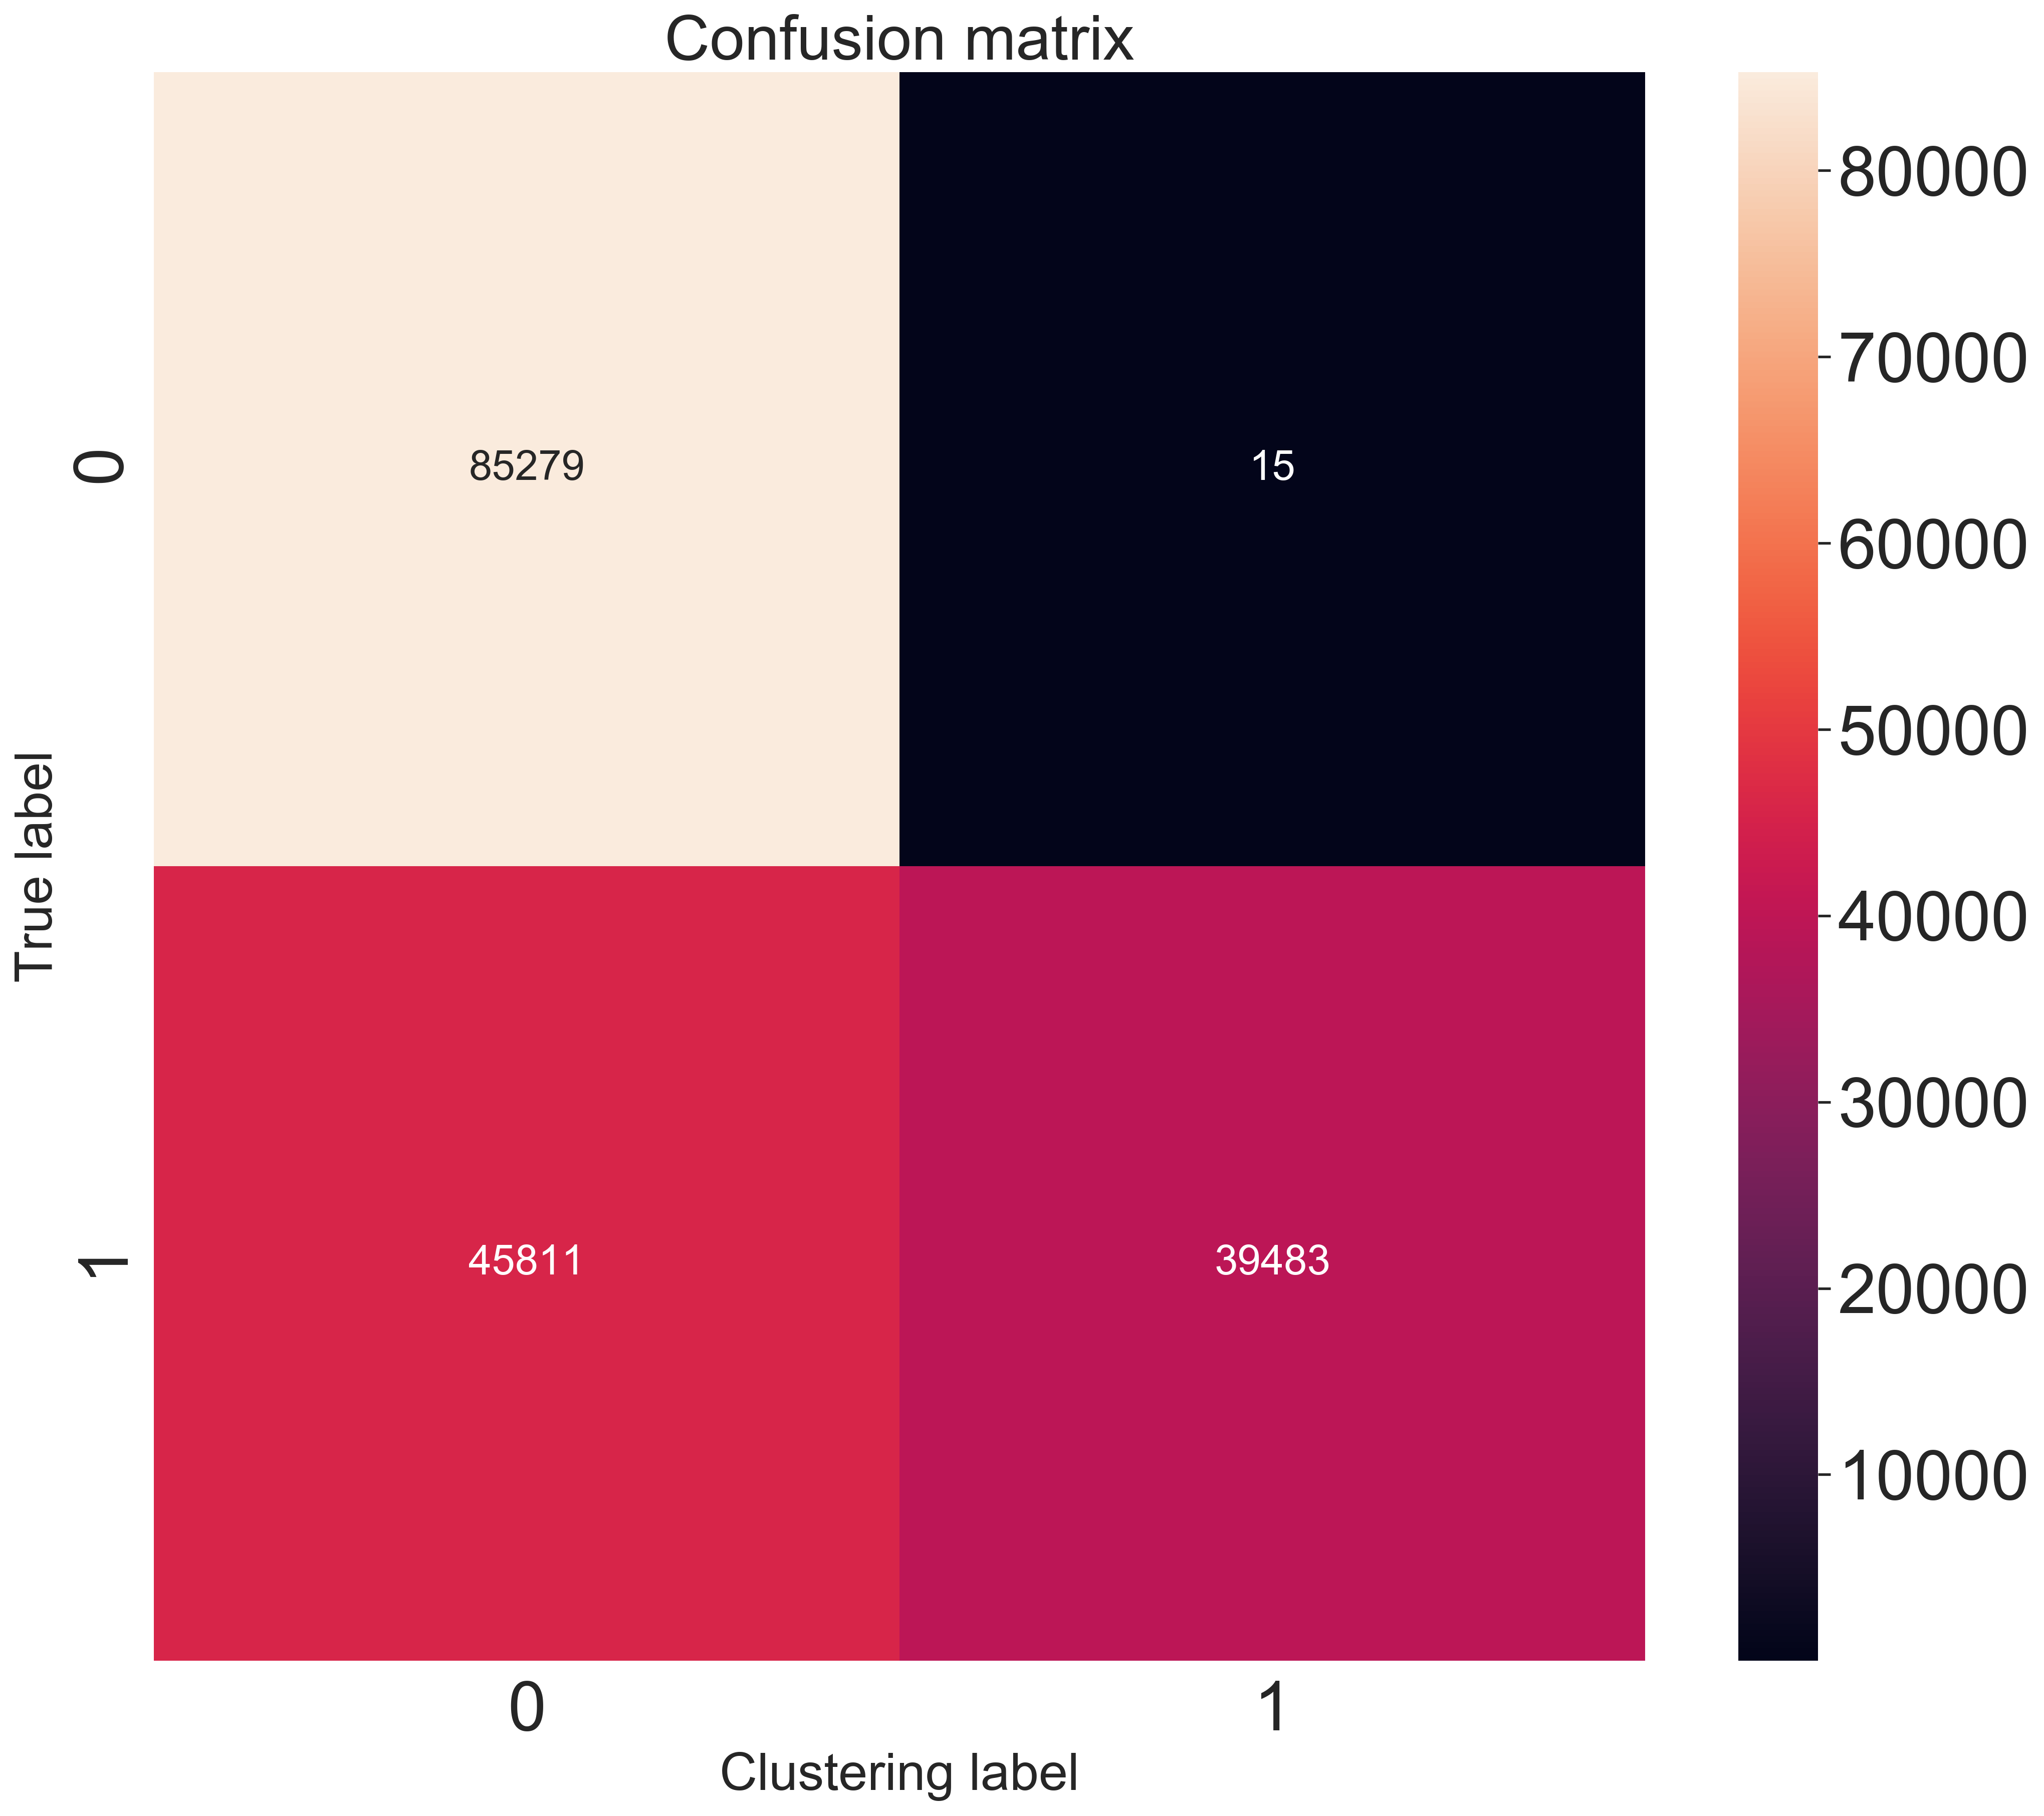

In [15]:
# Display confusion matrix for K-means
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred_kmeans)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [16]:
TN = confusion_matrix[0][0] # True Negative
FP = confusion_matrix[0][1] # False Positive
FN = confusion_matrix[1][0] # False Negative
TP = confusion_matrix[1][1] # True Positive

In [17]:
# Recall
TP/(TP+FN)

0.46290477642038125

In [16]:
# Specificity
TN/(TN+FP)

0.999824137173005

In [17]:
# False Positive Rate (FPR)
FP/(FP+TN)

0.9999187510881551

In [18]:
# Precision
TP/(TP+FP)

0.34621952052455435

In [23]:
y_imb.shape

(284807,)

### 2.4 Evaluate model on imbalanced data

In [24]:
# Store predictions in y_pred_kmeans
y_pred_kmeans = kmeans.predict(X_imb)

In [25]:
metrics.acc(y_imb, y_pred_kmeans)

c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


0.9989361216543132

In [26]:
# Print the number of predicted instances in each class.
collections.Counter(y_pred_kmeans)

Counter({1: 284534, 0: 273})

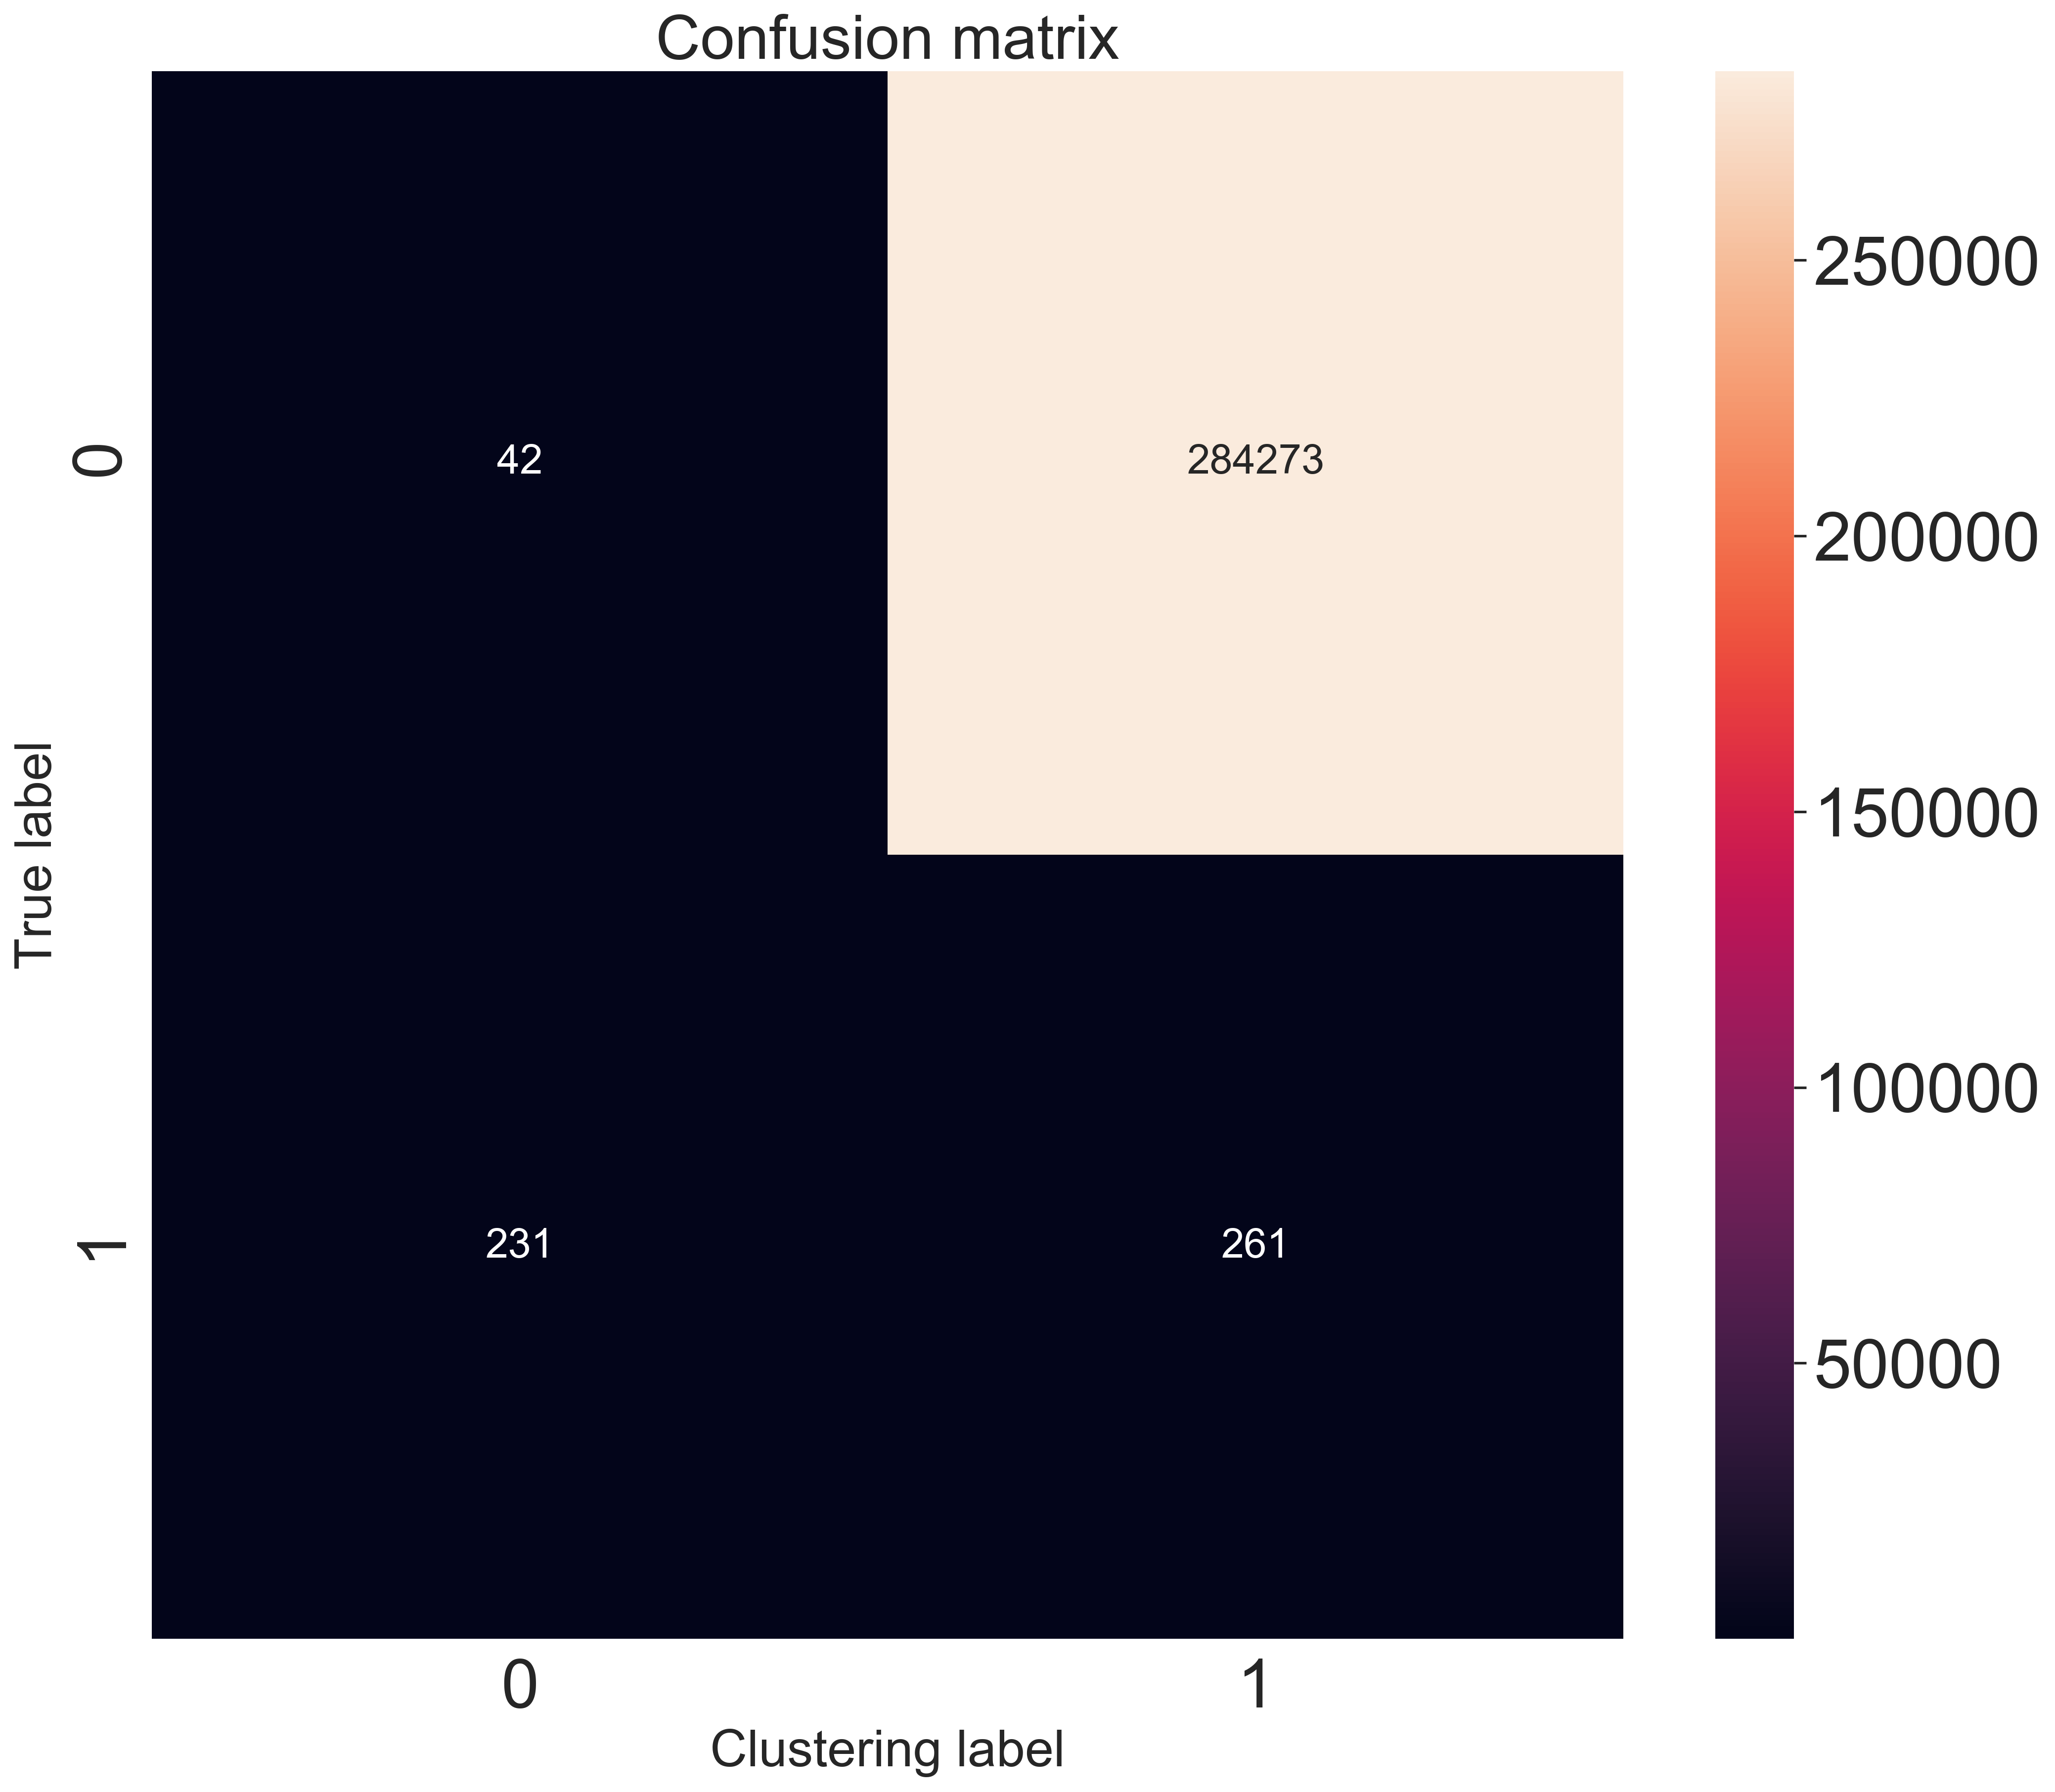

In [28]:
# Display confusion matrix for K-means
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y_imb, y_pred_kmeans)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [29]:
TN = confusion_matrix[0][0] # True Negative
FP = confusion_matrix[0][1] # False Positive
FN = confusion_matrix[1][0] # False Negative
TP = confusion_matrix[1][1] # True Positive

In [30]:
# Recall
TP/(TP+FN)

0.5304878048780488

In [31]:
# Specificity
TN/(TN+FP)

0.0001477234757223502

In [32]:
# False Positive Rate (FPR)
FP/(FP+TN)

0.9998522765242777

In [33]:
# Precision
TP/(TP+FP)

0.0009172893221899667

## 3. Autoencoder

In this section of the notebook, we provide the source code of the autoencoder, which is a data compression technique.

### 3.1 Build autoencoder

The first step is to build the autoencoder. The autoencoder is 
a symmetric deep neural network that learns how to reconstruct the input, and it consists of encoder and decoder, each has 4 densely connected layers each followed by activation function Relu.

In [9]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act , kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [10]:
# Hyper-params of the autoencoder

# Autoencoder architecture
dims = [X.shape[-1], 16, 16, 64, 6]

# Autoencoder initialization
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')

pretrain_optimizer = Adam(lr=0.0005)
pretrain_epochs = 10
batch_size = 512
save_dir = './results'

In [11]:
#Create autoencoder
autoencoder, encoder = autoencoder(dims, init=init)

In [12]:
# Display a summary of the autoencoder architecture
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 29)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 16)                480       
_________________________________________________________________
encoder_1 (Dense)            (None, 16)                272       
_________________________________________________________________
encoder_2 (Dense)            (None, 64)                1088      
_________________________________________________________________
encoder_3 (Dense)            (None, 6)                 390       
_________________________________________________________________
decoder_3 (Dense)            (None, 64)                448       
_________________________________________________________________
decoder_2 (Dense)            (None, 16)                1040     

In [13]:
# Display a summary of the encoder architecture
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 29)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 16)                480       
_________________________________________________________________
encoder_1 (Dense)            (None, 16)                272       
_________________________________________________________________
encoder_2 (Dense)            (None, 64)                1088      
_________________________________________________________________
encoder_3 (Dense)            (None, 6)                 390       
Total params: 2,230
Trainable params: 2,230
Non-trainable params: 0
_________________________________________________________________


### 3.2 Pre-train autoencoder

In this step, we train the whole autoencoder for 10 epochs to reconstruct the input features using Adam optimizer and MSE loss function.

In [14]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/10
255882/255882 [==============================] - 4s 15us/step - loss: 0.0076
Epoch 2/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0036
Epoch 3/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0028
Epoch 4/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0024
Epoch 5/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0021
Epoch 6/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0019
Epoch 7/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0019
Epoch 8/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0018
Epoch 9/10
255882/255882 [==============================] - 3s 13us/step - loss: 0.0017
Epoch 10/10
255882/255882 [==============================] - 4s 14us/step - loss: 0.0016


### 3.3 Feature space visualization

Here we use TSNE algorithm to visualize how data points are distributed across the feature space after has been compressed by the encoder using a sample of only 6000 instances.

In [19]:
#Build the model
tsne = TSNE(n_components=2)

#Fit the model and transform the features
X_embedded = tsne.fit_transform(encoder.predict(X))
print("X_embedded shape: ", X_embedded.shape)

X_embedded shape:  (6285, 2)


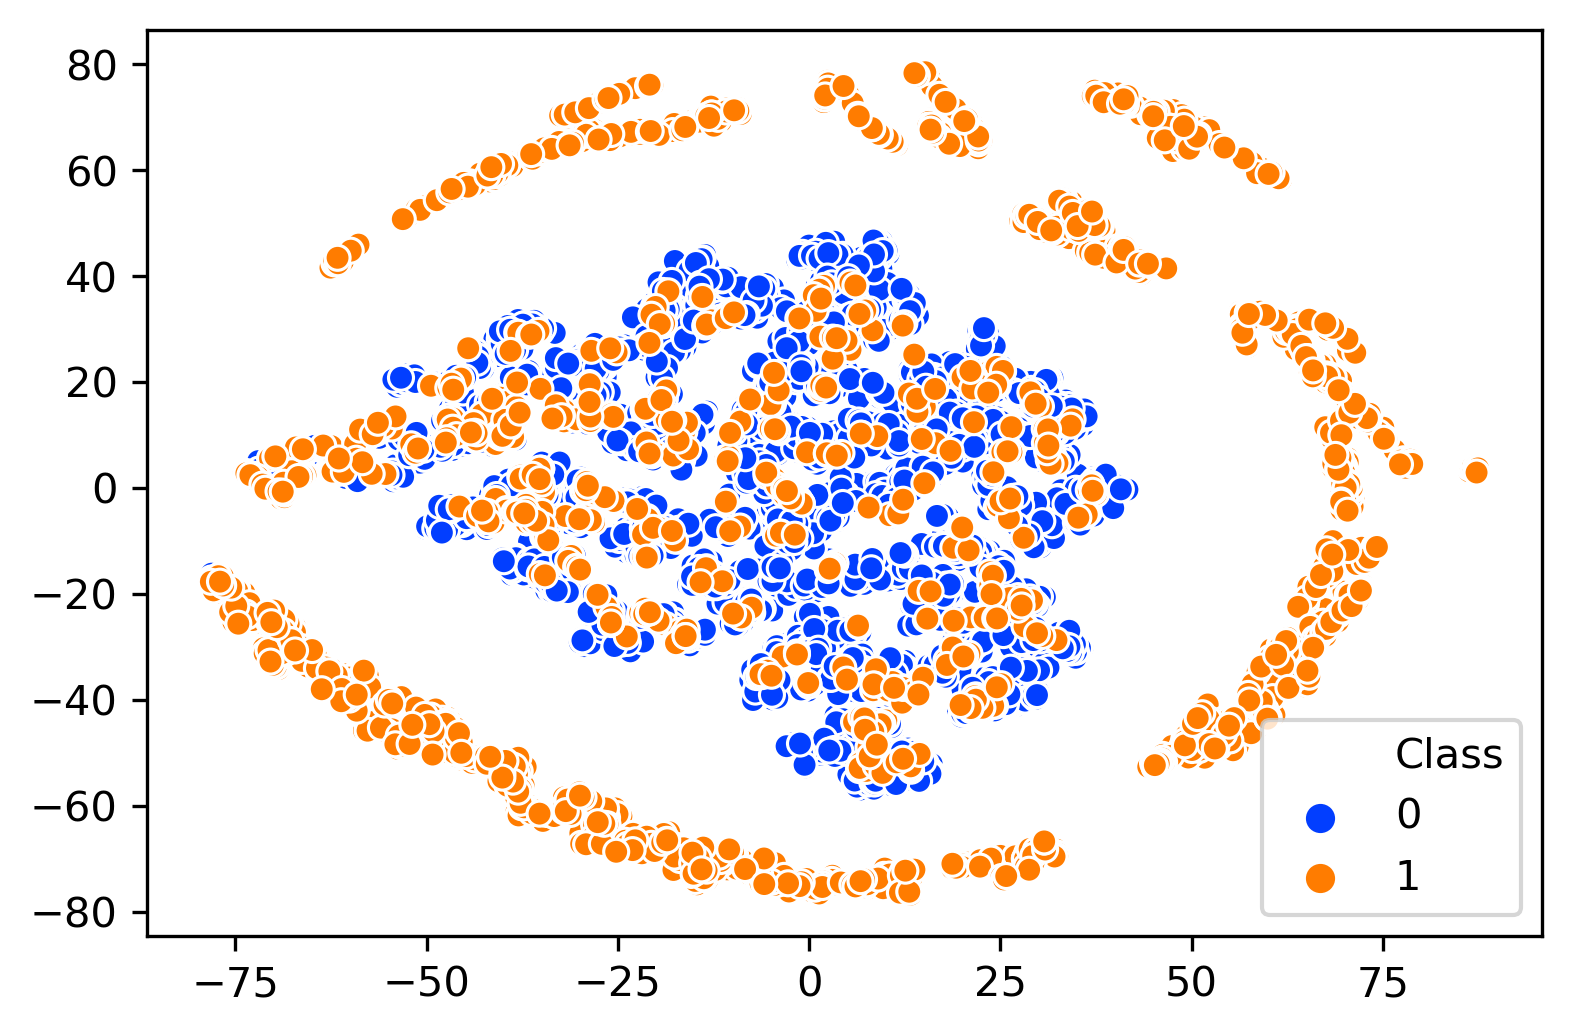

In [20]:
# Scatter plot the transformed features
palette = sns.color_palette("bright", 2)
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, palette=palette)

## 4. Deep Embedded clustering (DEC)

In this section of the notebook, we provide the source code for the novel solution of applying deeply embedded clustering to credit card fraud detection dataset.

### 4.1 Build DEC model

The first step is to build the DEC model. We do that by taking the encoder part from the pre-trained autoencoder and then stacks on top of it a clustering layer that works as a k-means model.

In [15]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [16]:
# Create instance of clustering layer
clustering_layer = ClusteringLayer(2, name='clustering')(encoder.output)
# Create the DEC model
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 29)                0         
_________________________________________________________________
encoder_0 (Dense)            (None, 16)                480       
_________________________________________________________________
encoder_1 (Dense)            (None, 16)                272       
_________________________________________________________________
encoder_2 (Dense)            (None, 64)                1088      
_________________________________________________________________
encoder_3 (Dense)            (None, 6)                 390       
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 12        
Total params: 2,242
Trainable params: 2,242
Non-trainable params: 0
_________________________________________________________

### 4.2 Initialize cluster centers

Here we initialize the clustering layer with k-means centroids. We do that by running the k-means 20 times with maximum iterations of 300 and choosing the best run.

In [17]:
#Create k-means
kmeans = KMeans(n_clusters=2, max_iter=3000, n_init=20)

# Fit k-means and then store predicted labels in y_pred
y_pred = kmeans.fit_predict(encoder.predict(X))

y_pred_last = np.copy(y_pred)

#Initialize the clustring layer
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### 4.3 Train DEC model

Here we jointly train the encoder with the clustering layer with the help of an auxiliary target distribution to further improve the clustering performance.

In [18]:
# computing an auxiliary target distribution
# Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [23]:
# Hyperparameters

loss = 0
index = 0
tol = 0.0001 # tolerance threshold to stop training
maxiter = 4000
update_interval = 140
index_array = np.arange(X.shape[0])
model.compile(optimizer=Adam(lr=0.0005), loss='kld')

In [24]:
# Start training
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
    loss = model.train_on_batch(x=np.asarray(X)[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final_3.h5')

c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 0: acc = 0.93244, nmi = 0.67444, ari = 0.74174  ; loss= 0


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.93090, nmi = 0.66932, ari = 0.73621  ; loss= 0.01271


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.91045, nmi = 0.60481, ari = 0.66410  ; loss= 0.02035


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.93367, nmi = 0.67844, ari = 0.74617  ; loss= 0.03761


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 560: acc = 0.93375, nmi = 0.67859, ari = 0.74648  ; loss= 0.02728
Iter 700: acc = 0.93375, nmi = 0.67858, ari = 0.74647  ; loss= 0.02888
delta_label  3.908051367427173e-06 < tol  0.0001
Reached tolerance threshold. Stopping training.


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


### 4.4 Evaluate DEC on balanced data

In [25]:
loss = 0
# Eval.
q = model.predict(X, verbose=0)

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.93375, nmi = 0.67858, ari = 0.74647  ; loss= 0


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [26]:
# Save the soft assignment (q) of the current run on the re-sampled data for future ensembling
pickle.dump(q, open("ensemble_balanced/q_3.pkl", "wb"))

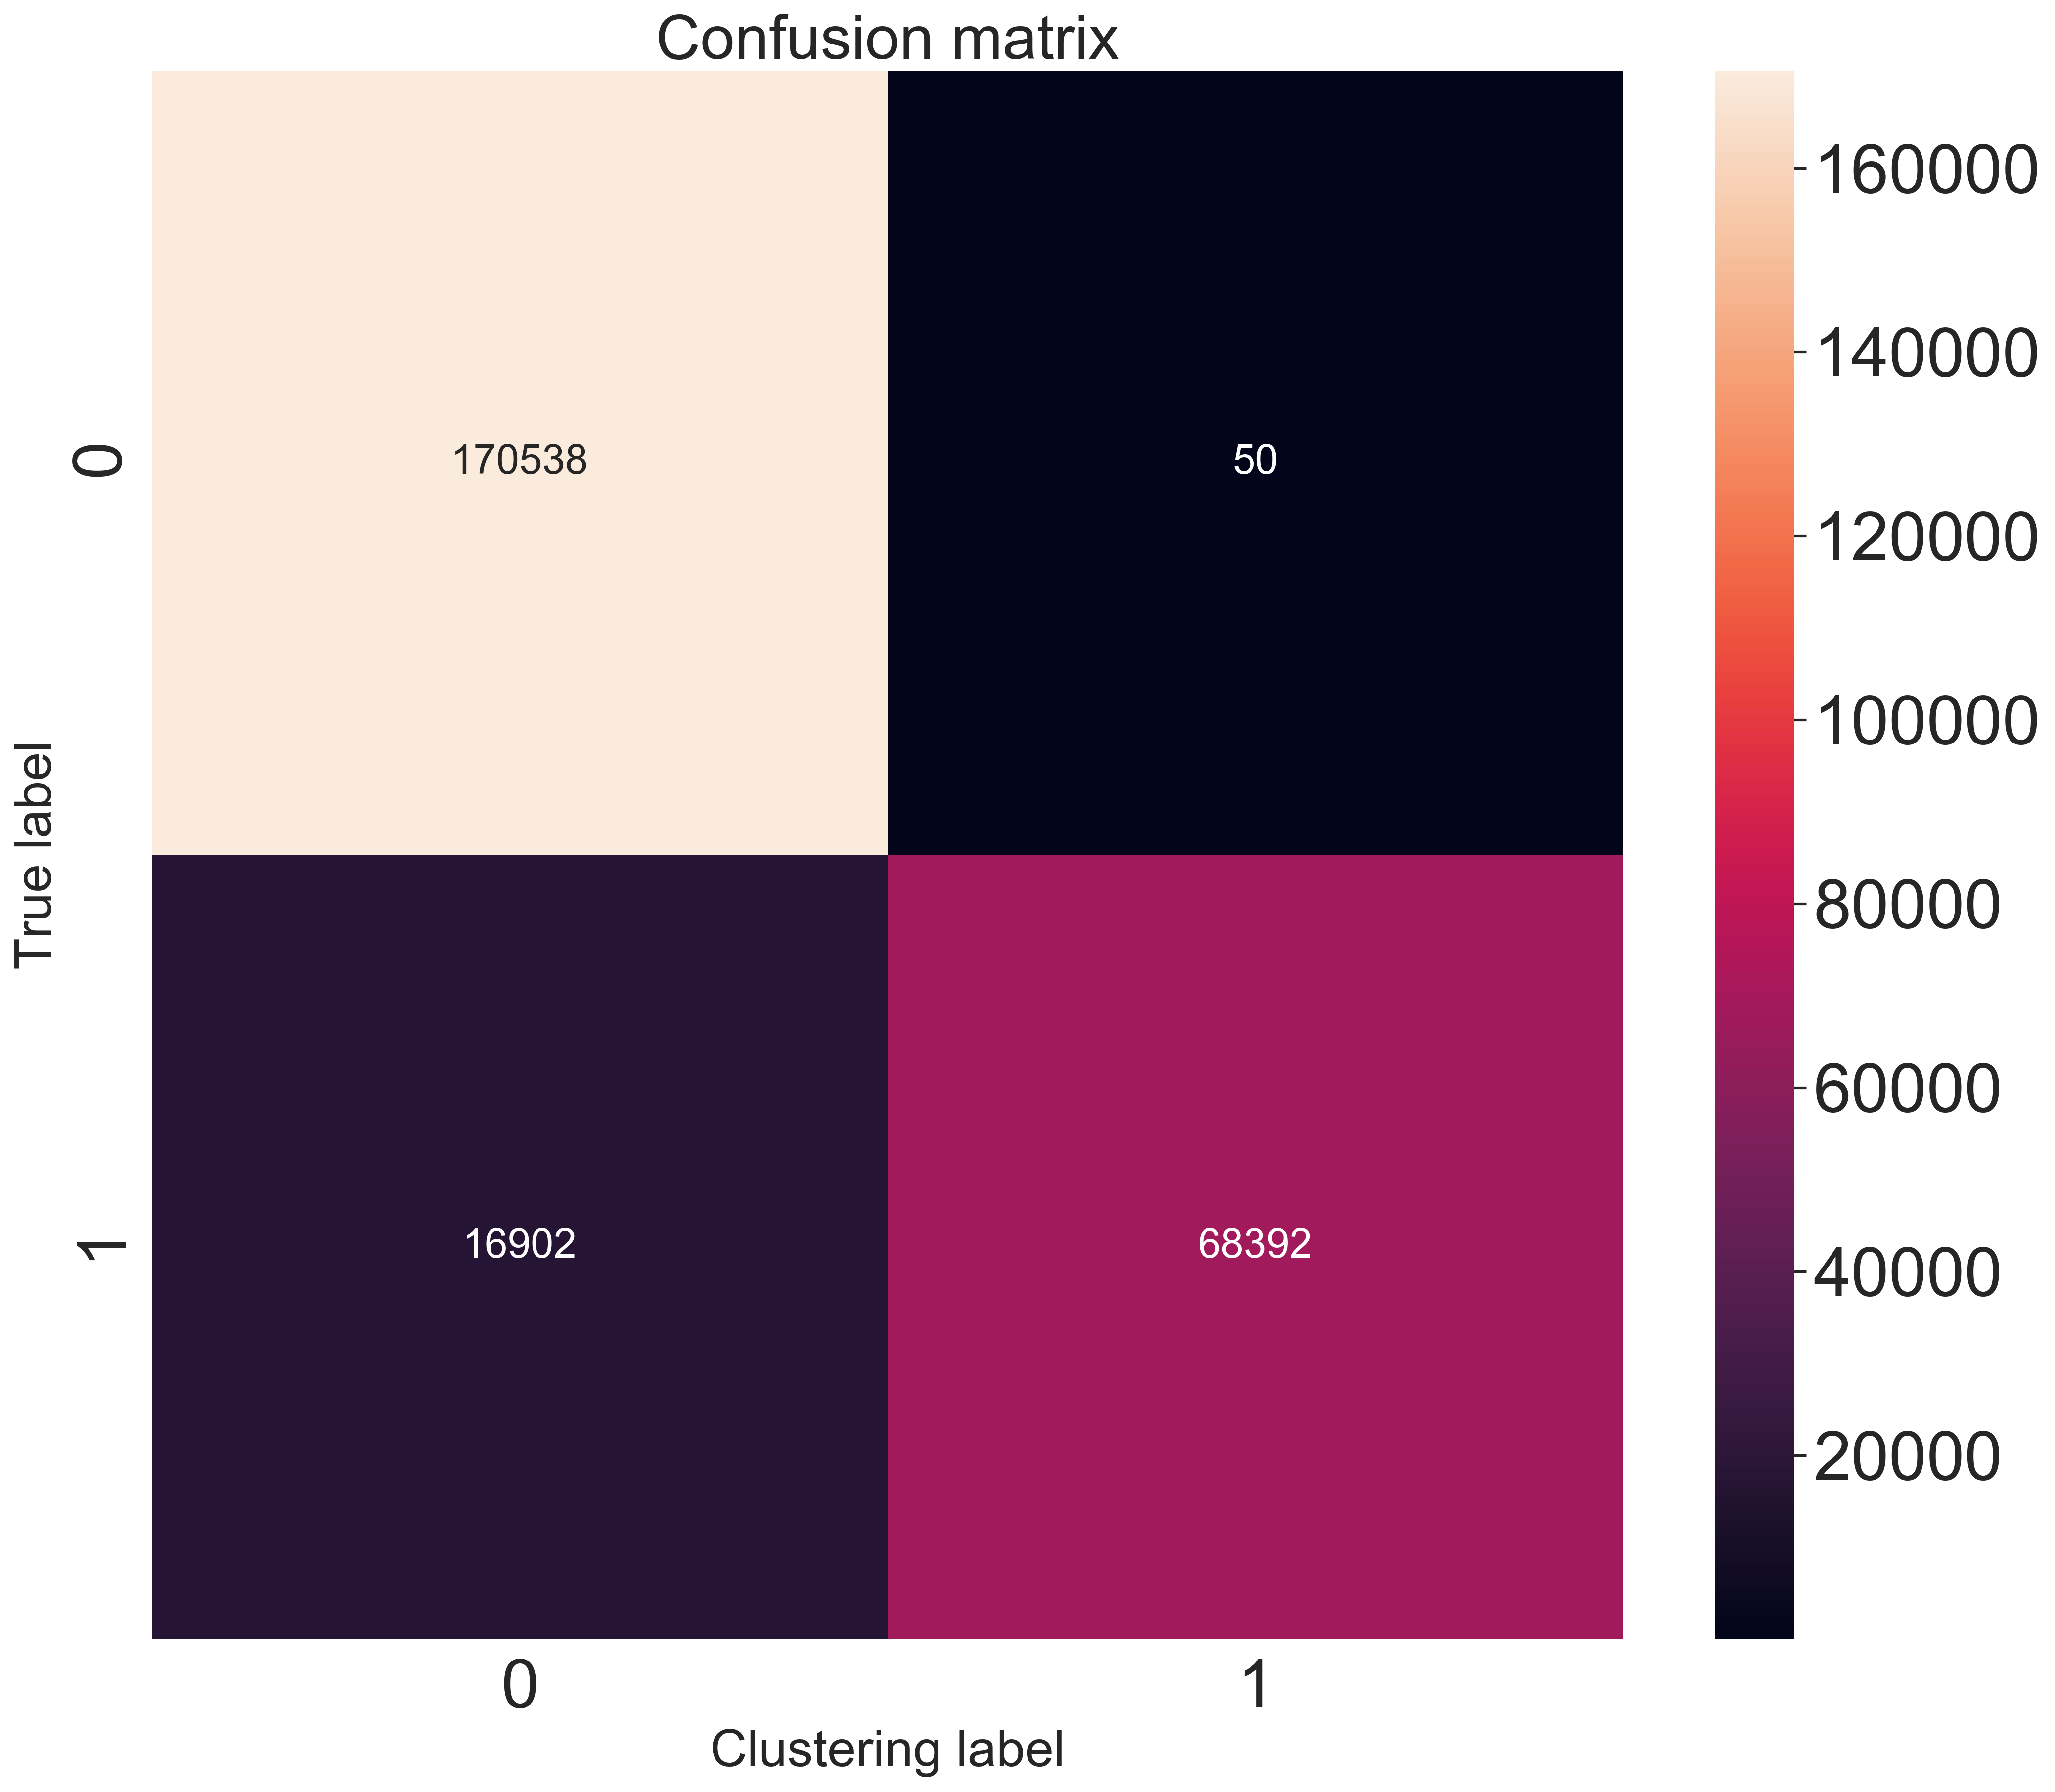

In [27]:
# Display confusion matrix for DEC
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [28]:
TN = confusion_matrix[0][0] # True Negative
FP = confusion_matrix[0][1] # False Positive
FN = confusion_matrix[1][0] # False Negative
TP = confusion_matrix[1][1] # True Positive

In [29]:
# Recall
TP/(TP+FN)

0.8018383473632378

In [28]:
# Specificity
TN/(TN+FP)

0.999779467239278

In [29]:
# False Positive Rate (FPR)
FP/(FP+TN)

0.00022053276072195462

In [30]:
# Precision
TP/(TP+FP)

0.9997226074895977

### 4.5 Evaluate DEC on imbalanced data

In [31]:
loss = 0
# Eval.
q = model.predict(X_imb, verbose=0)
# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y_imb, y_pred), 5)
    nmi = np.round(metrics.nmi(y_imb, y_pred), 5)
    ari = np.round(metrics.ari(y_imb, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.99937, nmi = 0.70673, ari = 0.81322  ; loss= 0


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [32]:
# Save the soft assignment (q) of the current run on the original imbalanced data for future ensembling
pickle.dump(q, open("ensemble_imbalanced/q_imb_3.pkl", "wb"))

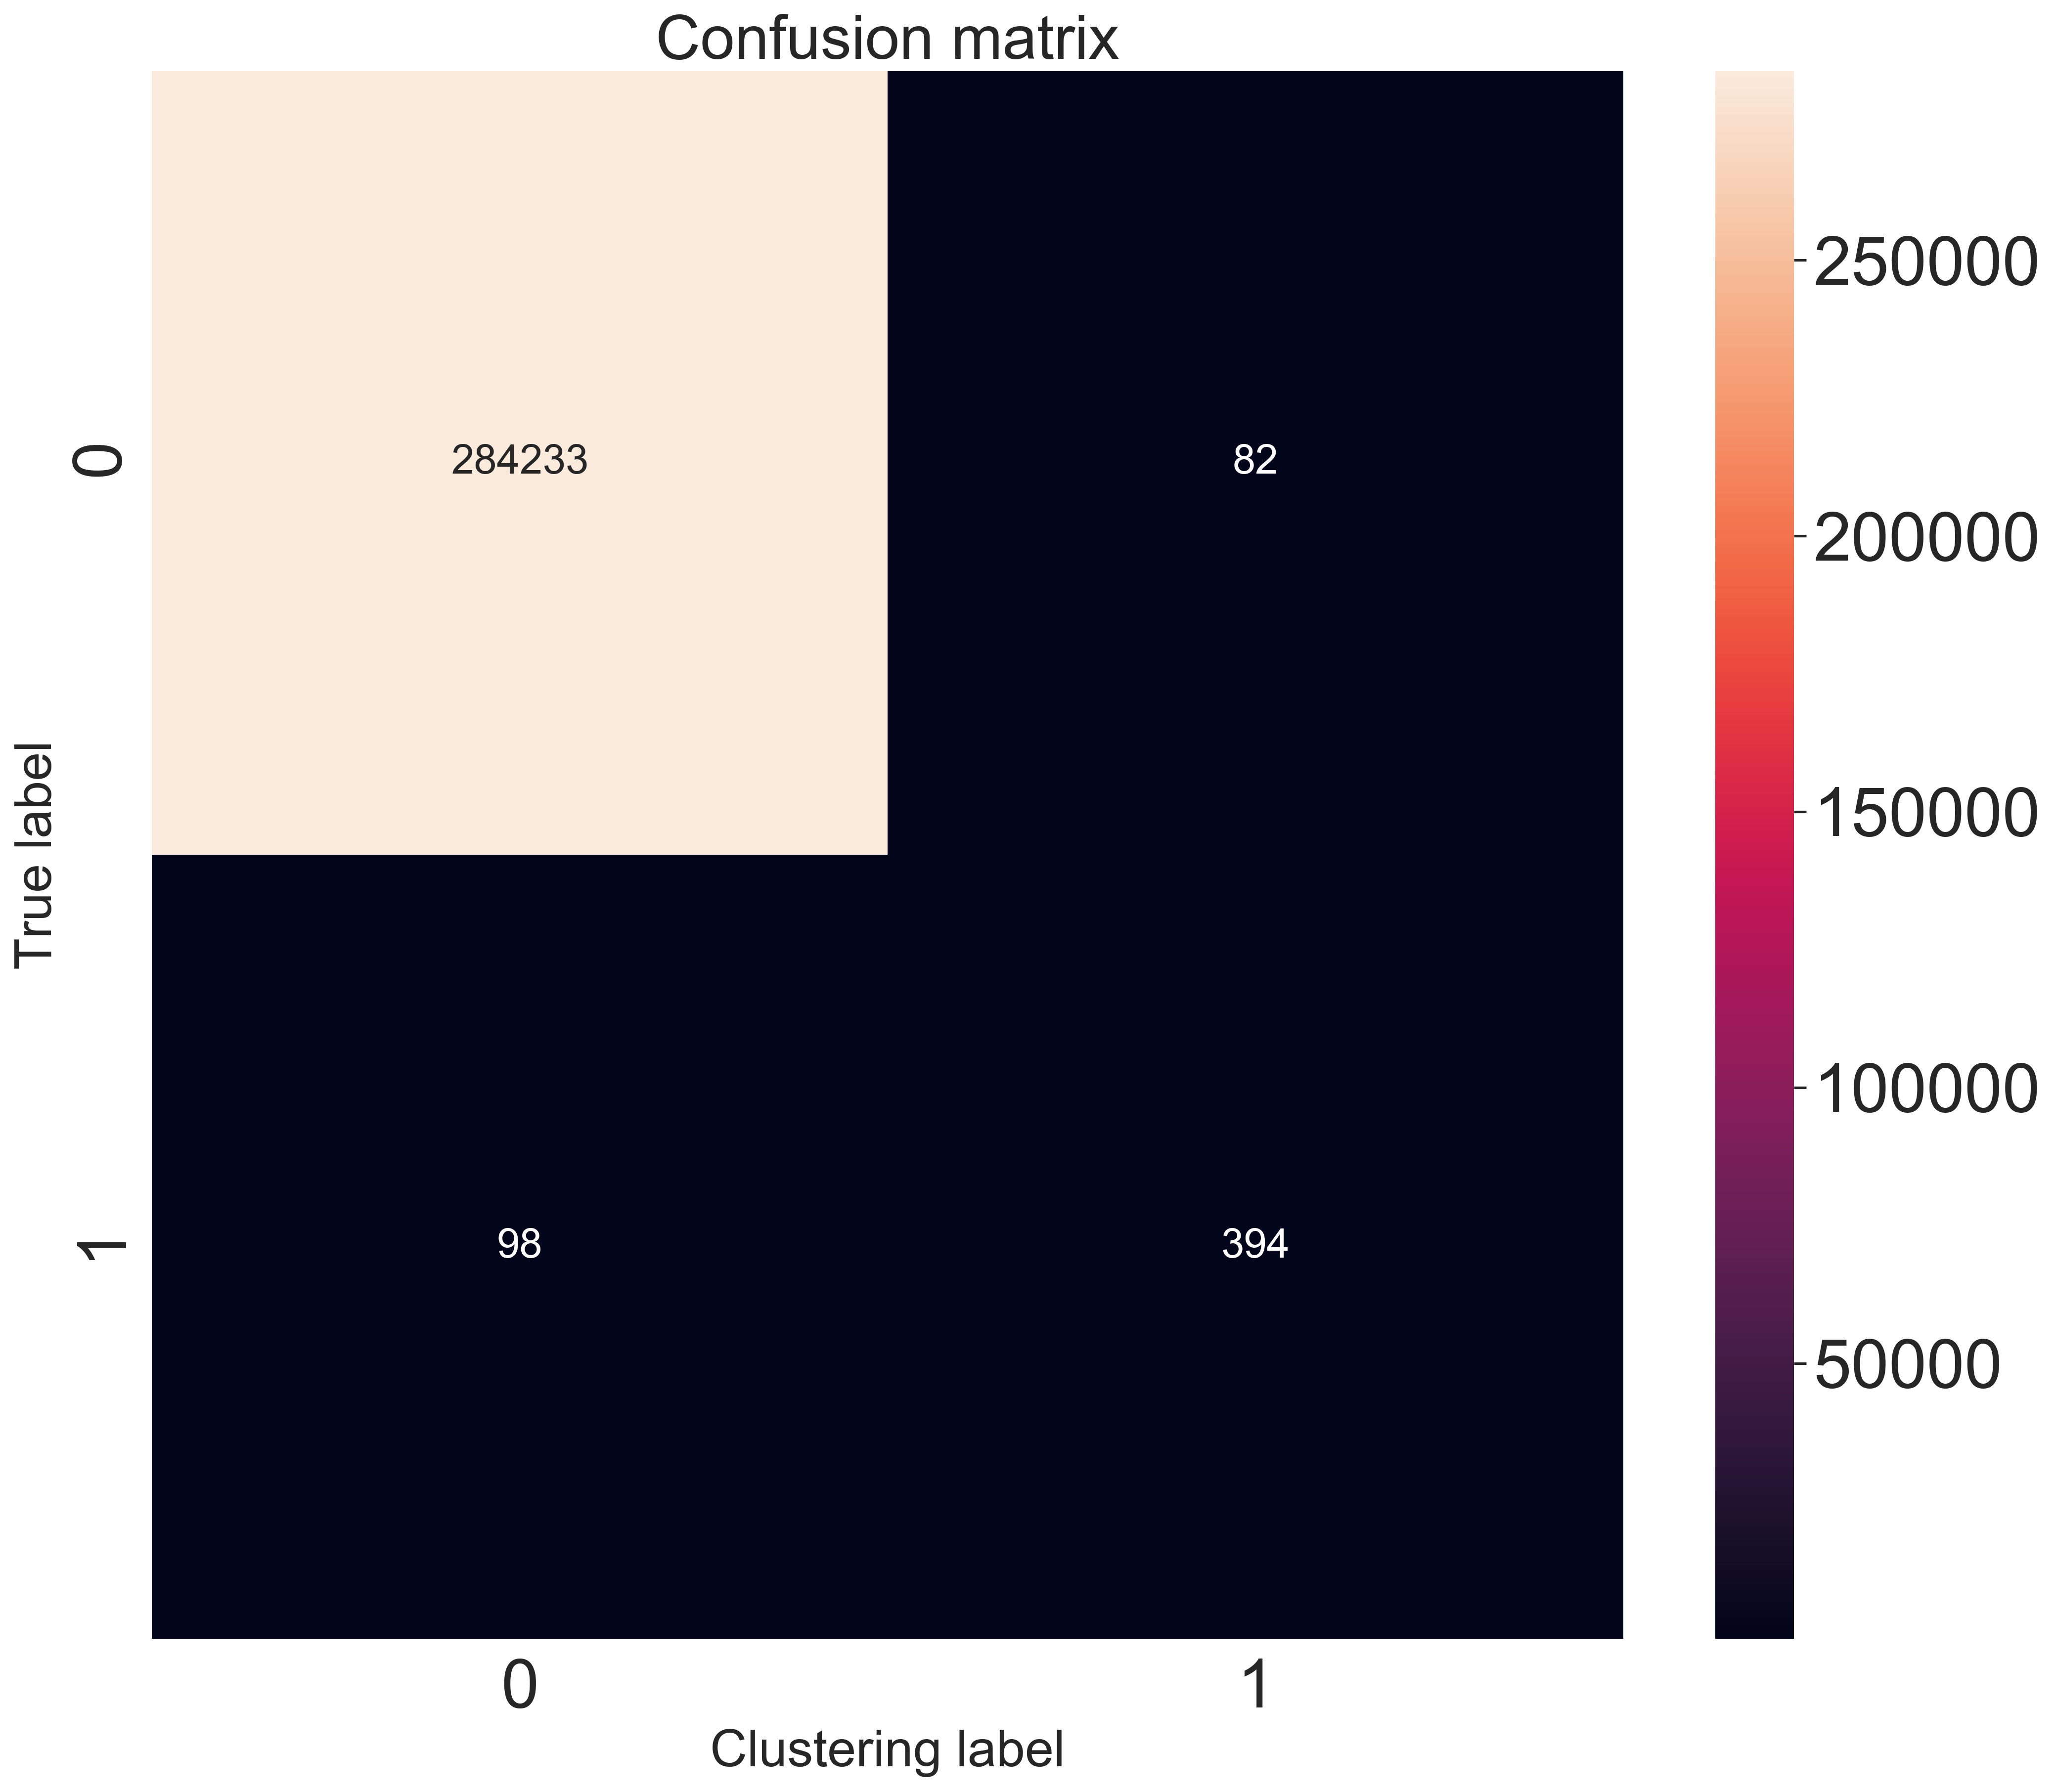

In [33]:
# Display confusion matrix for DEC
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y_imb, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [34]:
TN = confusion_matrix[0][0] # True Negative
FP = confusion_matrix[0][1] # False Positive
FN = confusion_matrix[1][0] # False Negative
TP = confusion_matrix[1][1] # True Positive

In [35]:
# Recall
TP/(TP+FN)

0.8008130081300813

In [36]:
# Specificity
TN/(TN+FP)

0.9997115874997802

In [37]:
# False Positive Rate (FPR)
FP/(FP+TN)

0.0002884125002198266

In [38]:
# Precision
TP/(TP+FP)

0.8277310924369747

### 4.6 Evaluate ensambled DEC on balanced data (Don't run now!!)
Run the following sections only after performing several runs on the previous section and if you saved the soft assignment (q) on both the re-sampled (balanced) data and the original data.
In this section, we average out the saved soft assignments (q_avg), then evaluate the ensemble performance.

In [30]:
q_1 = pickle.load(open("ensemble_balanced/q_1.pkl", "rb"))
q_2 = pickle.load(open("ensemble_balanced/q_2.pkl", "rb"))
q_3 = pickle.load(open("ensemble_balanced/q_3.pkl", "rb"))

q_avg = (q_1+q_2+q_3)/3

In [31]:
# evaluate EDEC performance
y_pred = q_avg.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.96615, nmi = 0.80345, ari = 0.86680  ; loss= 0


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


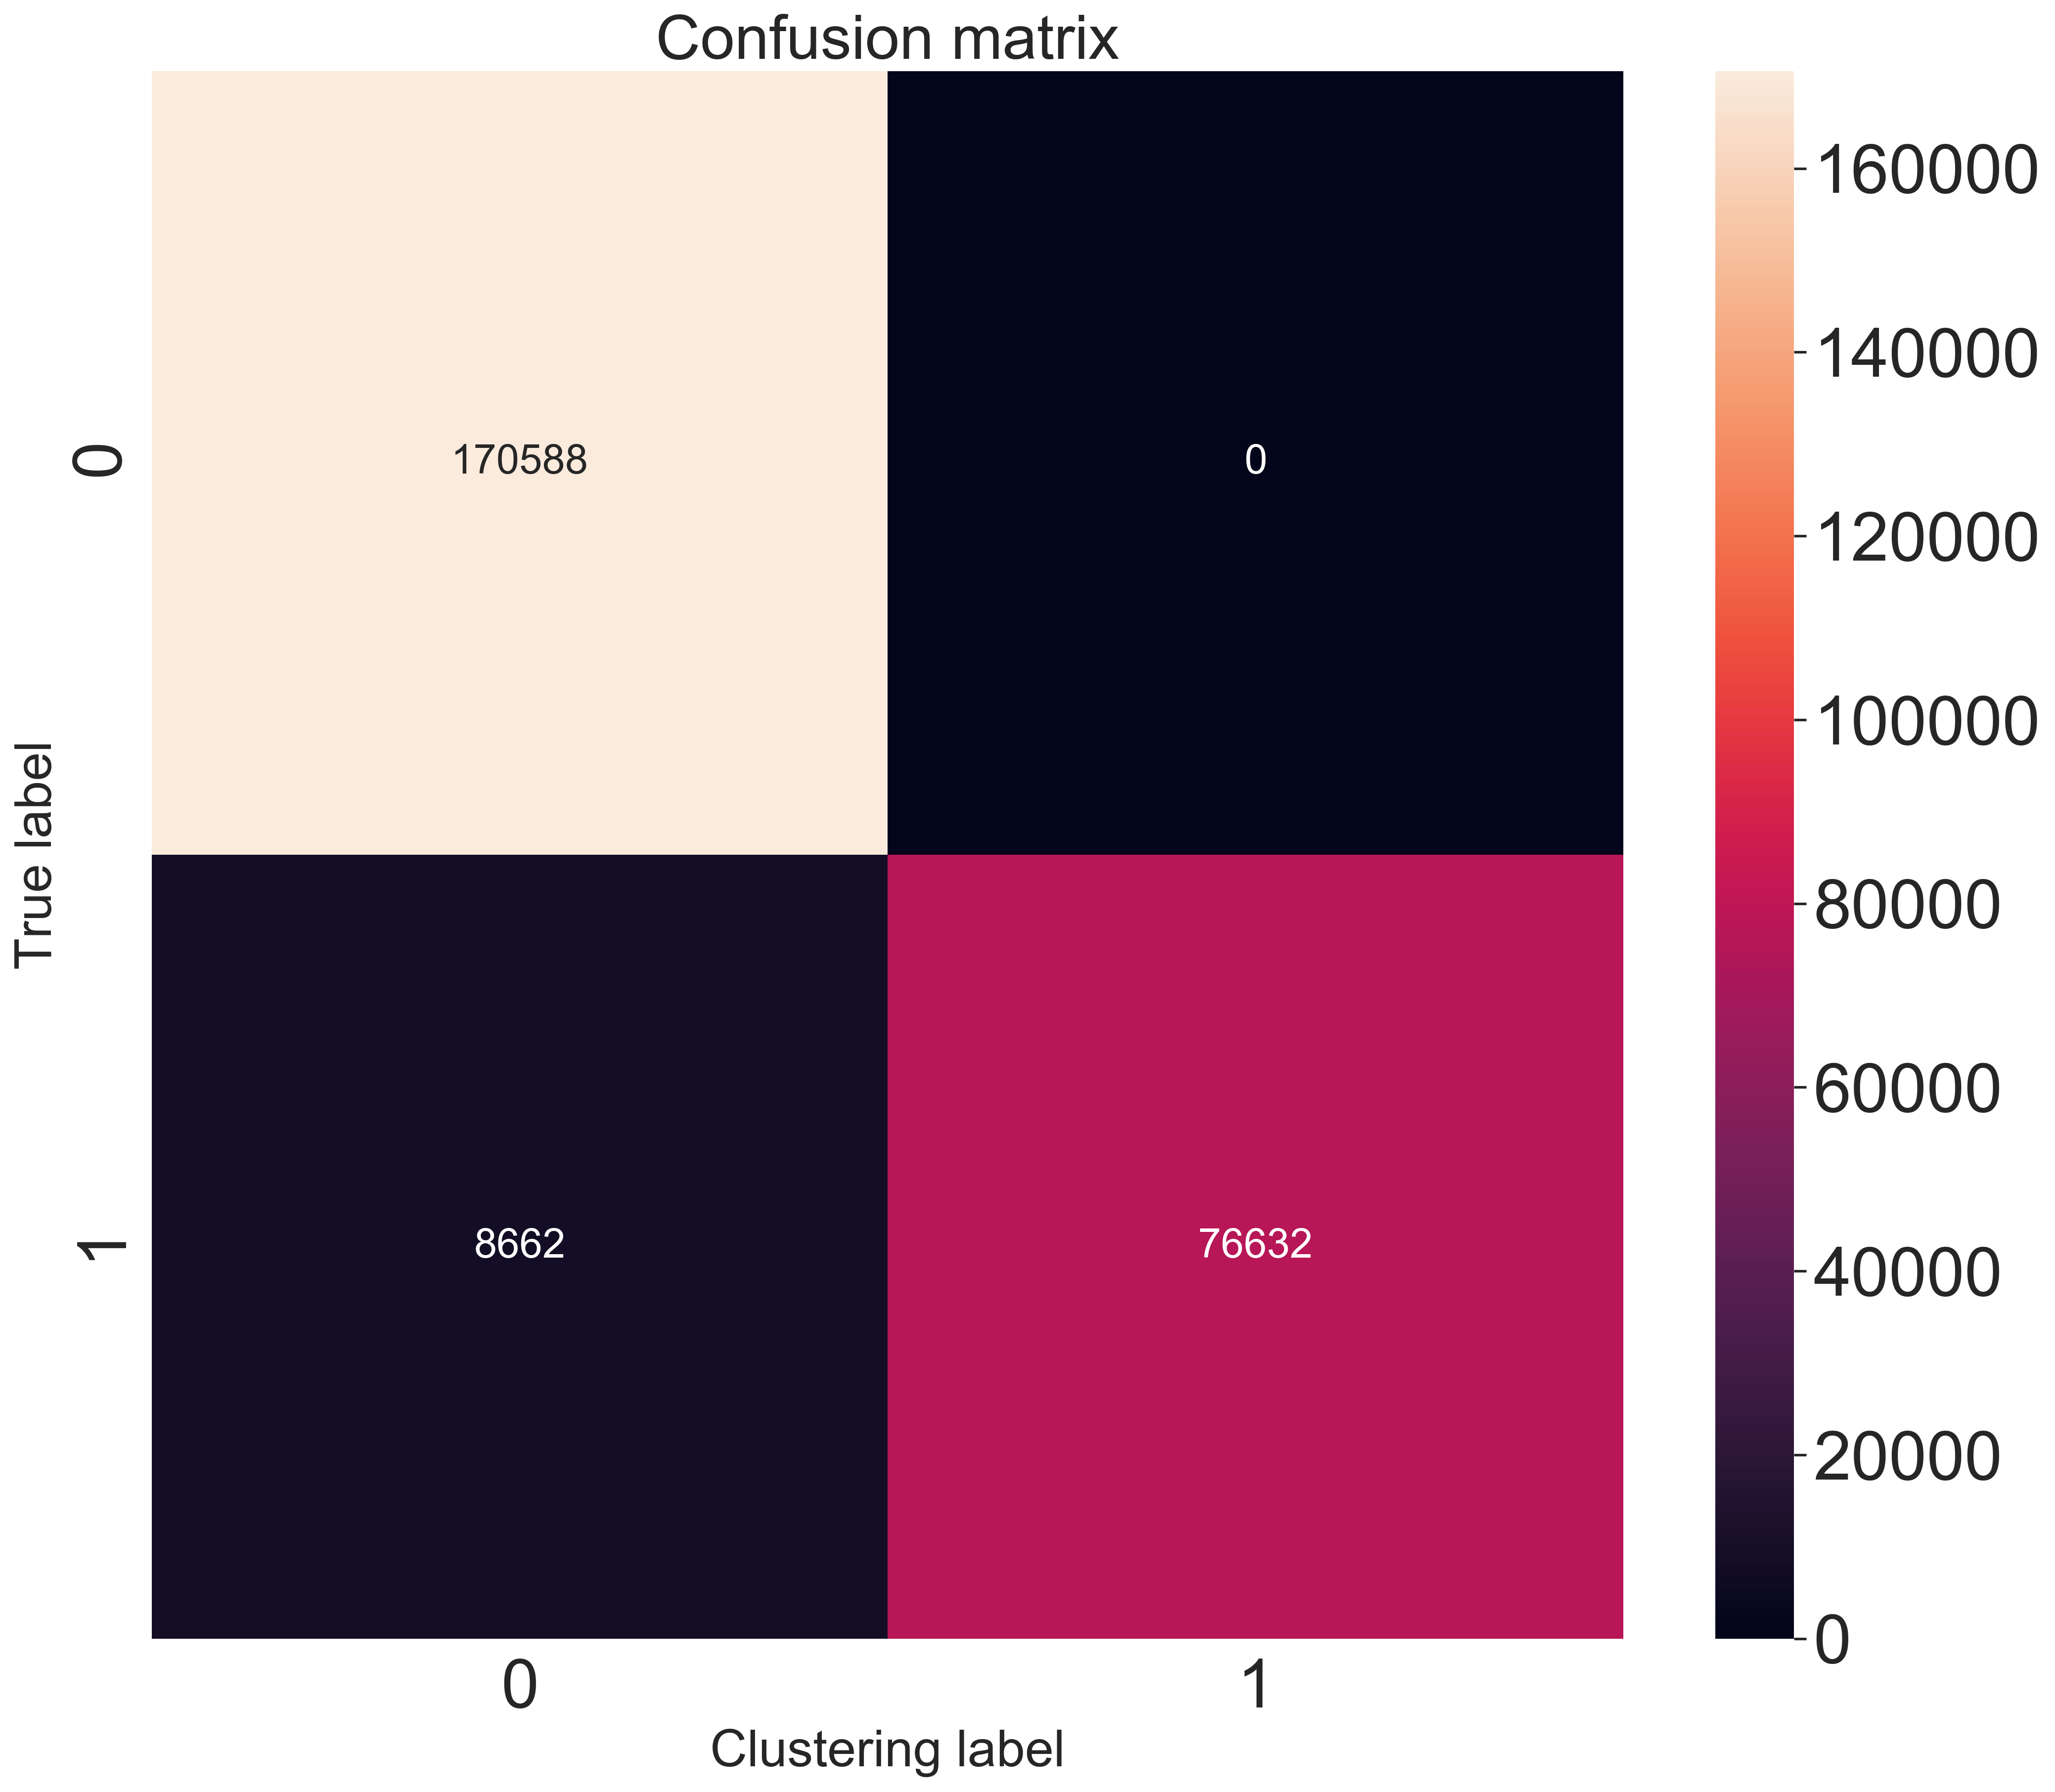

In [32]:
# Display confusion matrix for EDEC

sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### 4.7 Evaluate ensemble DEC on imbalanced data
In this section, we average out the saved soft assignments for imbalanced data (q_avg), then evaluate the ensemble performance.

In [42]:
q_1 = pickle.load(open("ensemble_imbalanced/q_imb_1.pkl", "rb"))
q_2 = pickle.load(open("ensemble_imbalanced/q_imb_2.pkl", "rb"))
q_3 = pickle.load(open("ensemble_imbalanced/q_imb_3.pkl", "rb"))

q_avg = (q_2+q_3+q_1)/3

In [43]:
# evaluate EDEC performance
y_pred = q_avg.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y_imb, y_pred), 5)
    nmi = np.round(metrics.nmi(y_imb, y_pred), 5)
    ari = np.round(metrics.ari(y_imb, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.99937, nmi = 0.70786, ari = 0.81406  ; loss= 0


c:\users\belal\anaconda3\envs\myenv\lib\site-packages\sklearn\utils\linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


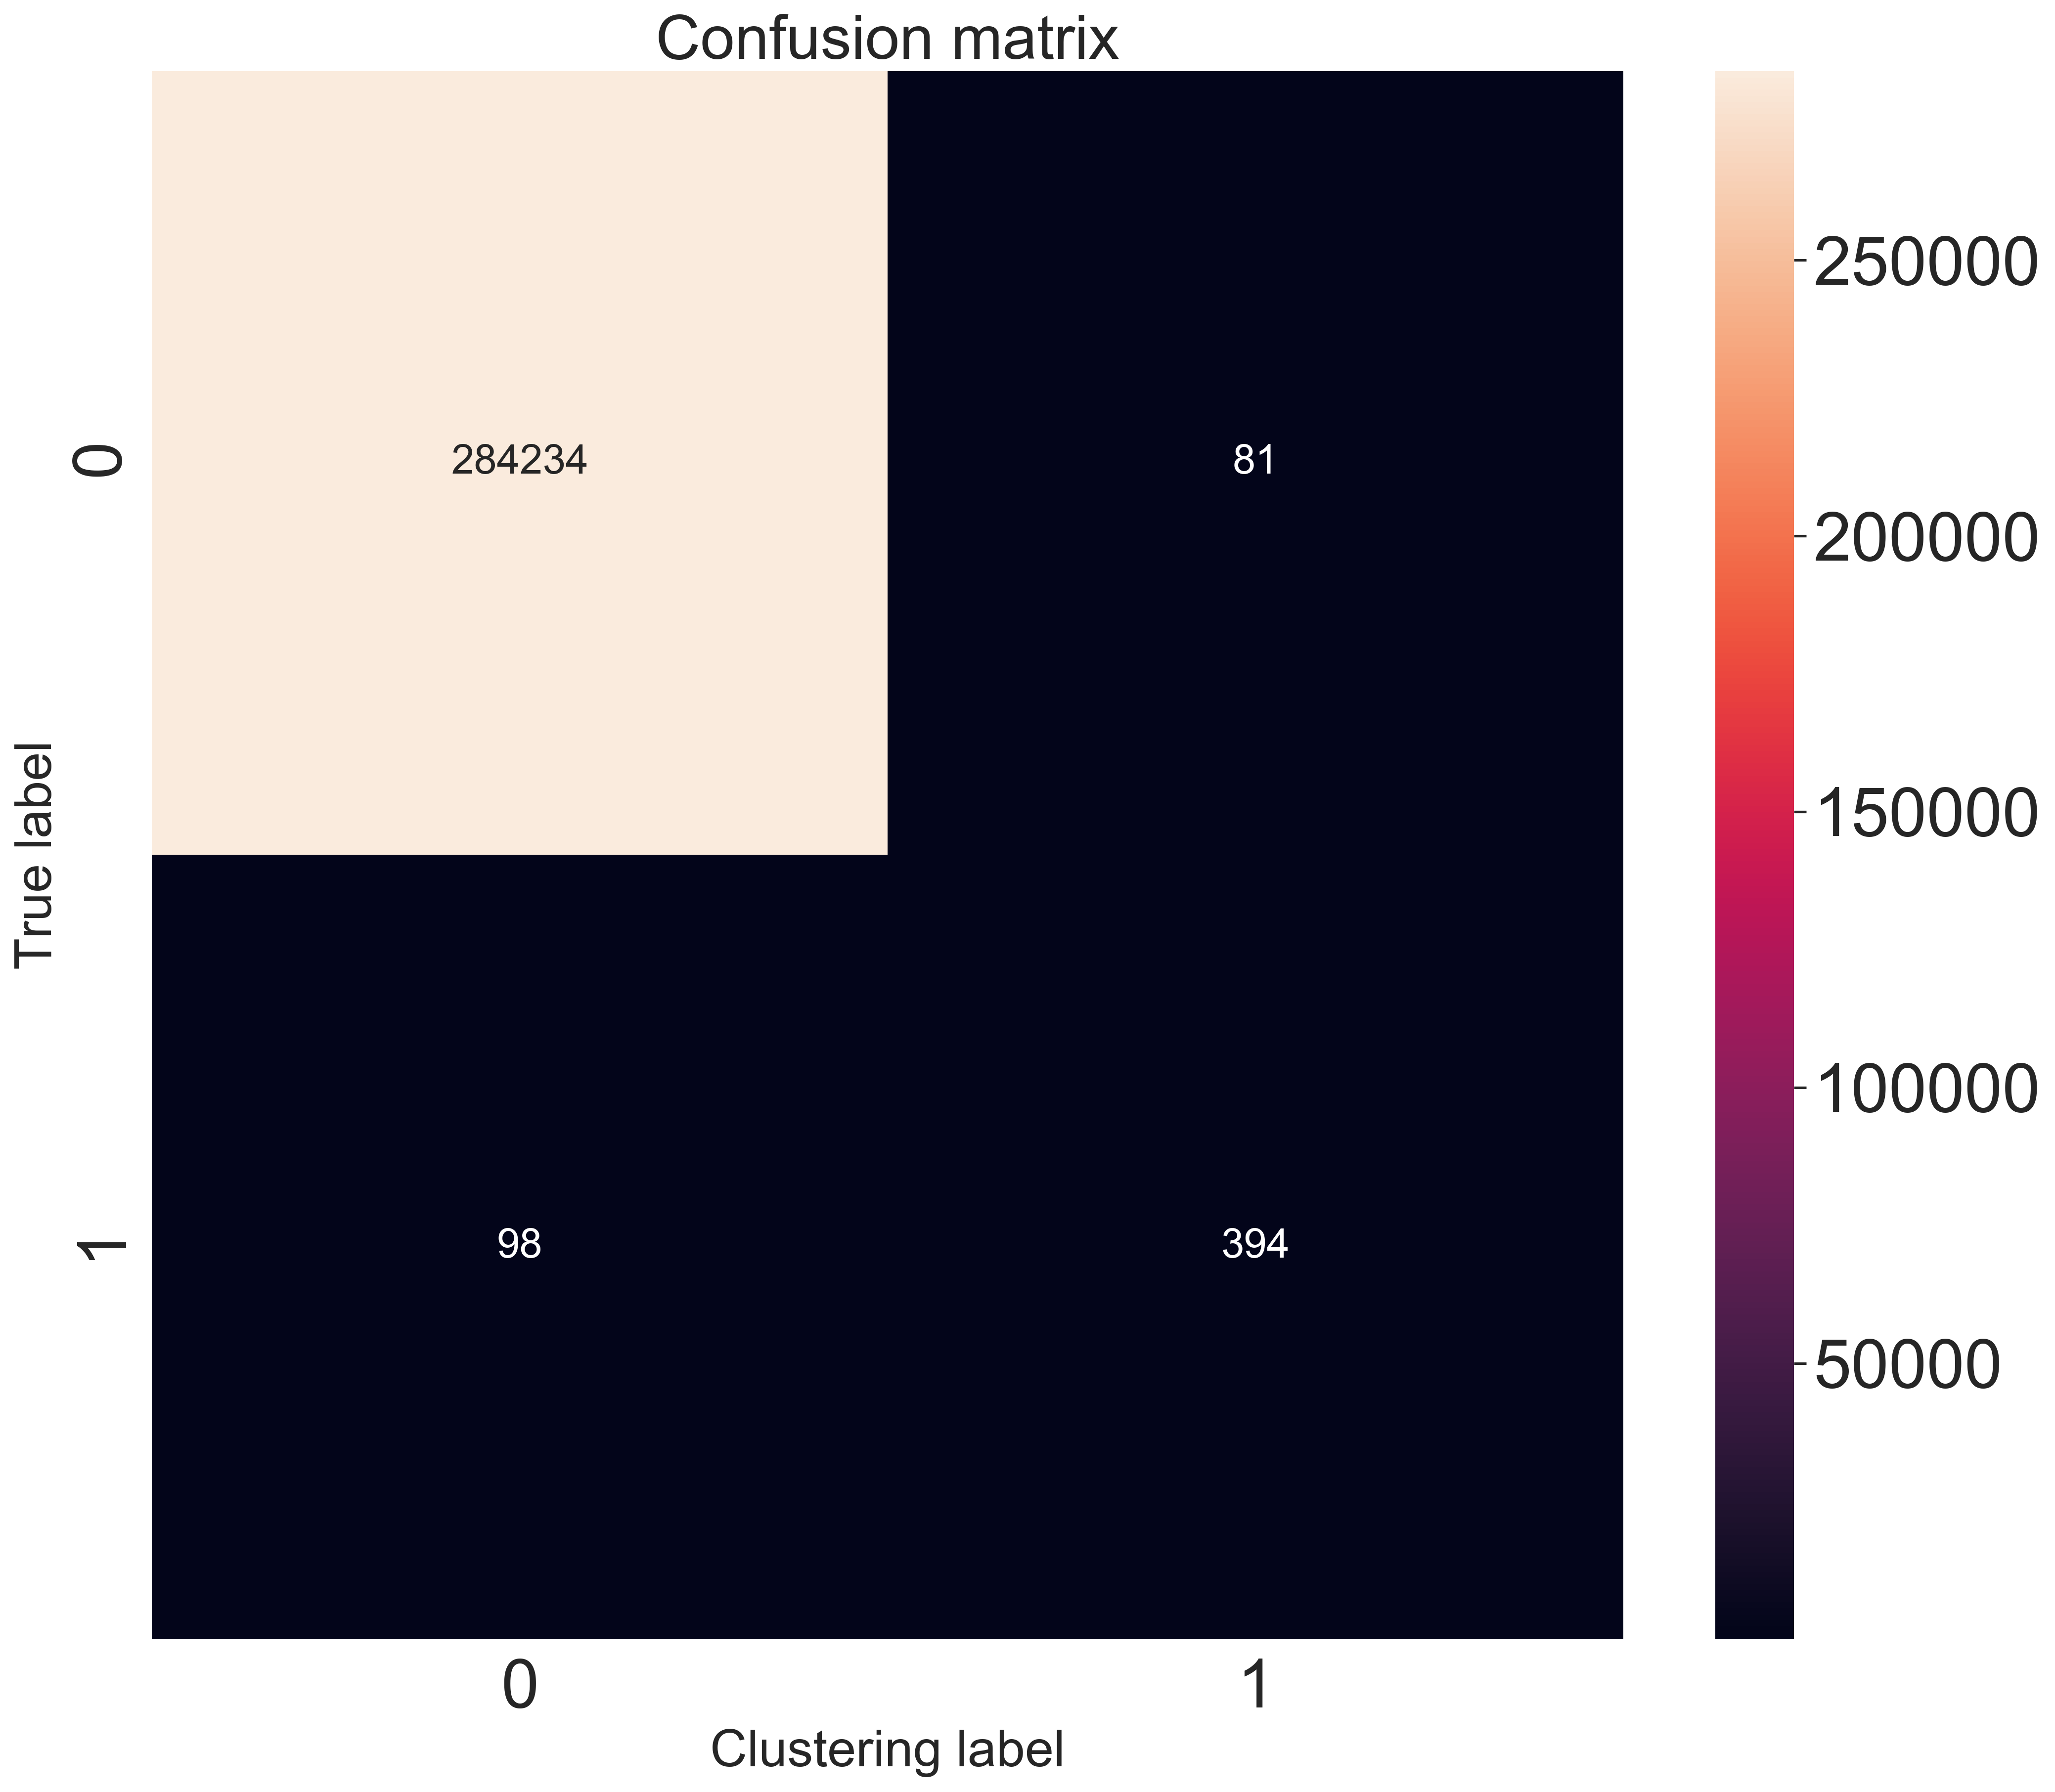

In [44]:
# Display confusion matrix for EDEC

sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y_imb, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()